In [1]:
%matplotlib notebook

In [3]:
import gym
from gym.envs.registration import register
import matplotlib as mpl
# mpl.use('agg')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import sys,time
from tiles3 import IHT, tiles


In [4]:
register(
    id='MountainCar-v1',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=5000,
    reward_threshold=-110.0,
)

In [5]:
env = gym.make('MountainCar-v1')
nA = 3
iht = IHT(4096)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
def _greedy(Q,s):
    qmax = np.max(Q(s))
    actions = []
    for i,q in enumerate(Q(s)):
        if q == qmax:
            actions.append(i)
    return actions

def greedy(Q,s):
    return np.random.choice(_greedy(Q,s))

def ep_greedy(Q,s,ep):
    if np.random.rand() < ep:
        return np.random.choice(len(Q(s)))
    else:
        return greedy(Q,s)
    
def qhat(params,default=0):
    # Estimate the action values using linear approximation.
    def qhatw(s):
        q = []
        for a in range(nA):
            qa = 0
            # Sum of params at active features is the action value.
            for i in feature(s,a):
                qa += params.setdefault(i,default)
            q.append(qa)
        return q
    return qhatw

def feature(state,action):
    # Return the indices of active features for state,action pair.
    # Use the tile-coding according to p246 of Sutton's book.
    x,xdot = state
    return tiles(iht,8,[8*x/(0.5+1.2),8*xdot/(0.07+0.07)],[action])

# This algorithm is implemented according to the pseudo-code on p305 of Sutton's book. 
def sarsalambda(env,feature,qhat,epsilon,alpha,lambda_,gamma,n_ep,replacing=True):
    w = {}
    episode = 0
    steps_list = []
    avg_steps = 0
    while episode < n_ep:
        s = env.reset()
        a = ep_greedy(qhat(w),s,epsilon)
        done = False
        steps = 0
        z = {}
        while not done:
#             env.render()
            ss,r,done,_ = env.step(a)
            steps += 1
            delta = r
            for i in feature(s,a):
                delta = delta - w.setdefault(i,0)
                if replacing:
                    z[i] = 1 # replacing traces
                else:
                    z[i] = z.setdefault(i,0) + 1 # accumulating traces
                    
            if done:
                for key,val in z.items():
                    w[key] = w.setdefault(key,0) + alpha * delta * val
                break
            aa = ep_greedy(qhat(w),ss,epsilon)
            for i in feature(ss,aa):
                delta = delta + gamma * w.setdefault(i,0)
            for key,val in z.items():
                w[key] = w.setdefault(key,0) + alpha * delta * val
                z[key] = gamma * lambda_ * val
            s,a = ss,aa
        episode += 1
        steps_list.append(steps)
        avg_steps = (avg_steps * (episode - 1) + steps) / episode
#         env.render()
    return avg_steps,steps_list

In [44]:
def plot_mountaincar_replacing():
    alpha_list = np.arange(0.6,2.0,0.2) / 8
    lambda_list = [0,0.9]
    epsilon = 0
    gamma = 1
    runs = 5
    n_ep = 50
    results = {}
    for lambda_ in lambda_list:
        results[lambda_] = []
        for alpha in alpha_list:
            temp = []
            for run in range(runs):
                avg_steps,_ = sarsalambda(env,feature,qhat,epsilon,alpha,lambda_,gamma,n_ep)
                temp.append(avg_steps)
                print('\rlambda:{:.2f},alpha:{:.2f},steps:{:.0f},run:{:<10}'.format(lambda_,alpha,avg_steps,run),end='')
                sys.stdout.flush()
            results[lambda_].append(np.mean(temp))
    fig = plt.figure()
    for lambda_ in lambda_list:
        print(results[lambda_])
        plt.plot(alpha_list,results[lambda_],label=r'$\lambda$={}'.format(lambda_))
    plt.title(r'Sarsa($\lambda$) with replacing traces')
    plt.xlabel(r'$\alpha\times 8$')
    plt.ylabel('average steps in 50 episodes')
    plt.legend()

lambda:0.96,alpha:0.23,steps:203,run:4         

<IPython.core.display.Javascript object>


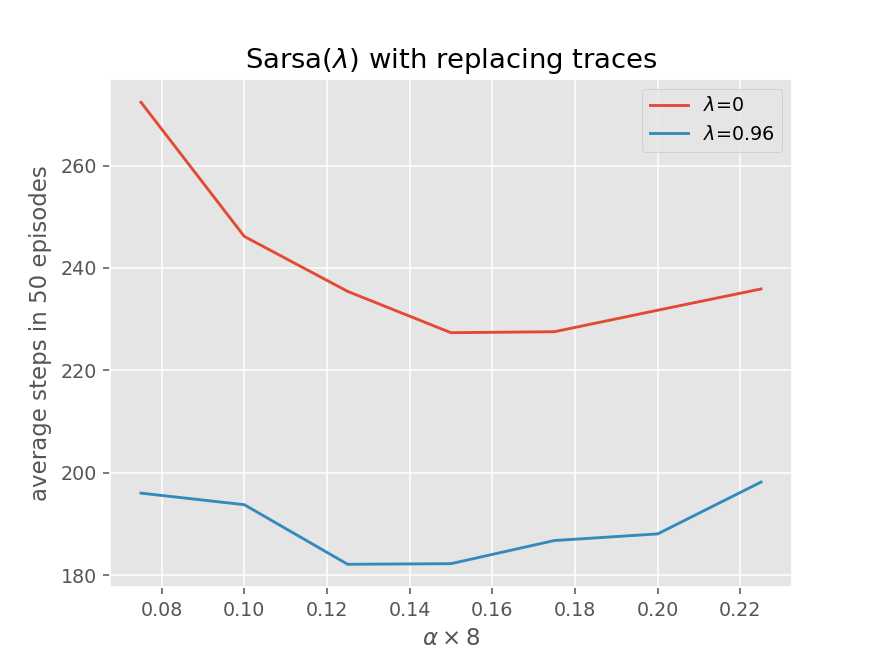

[272.37199999999996, 246.16, 235.42000000000002, 227.348, 227.54000000000002, 231.73999999999995, 235.89600000000002]
[196.0, 193.73600000000002, 182.092, 182.216, 186.736, 188.032, 198.16000000000003]
449.265625


In [45]:
t1 = time.process_time()
plot_mountaincar_replacing()
t2 = time.process_time()
print(t2-t1)

In [12]:
def plot_mountaincar_accumulating():
    alpha_list = np.arange(0.2,0.5,0.05) / 8
    lambda_list = [0,0.9]
    epsilon = 0
    gamma = 1
    runs = 5
    n_ep = 50
    results = {}
    for lambda_ in lambda_list:
        results[lambda_] = []
        for alpha in alpha_list:
            temp = []
            for run in range(runs):
                avg_steps,_ = sarsalambda(env,feature,qhat,epsilon,alpha,lambda_,gamma,n_ep,replacing=False)
                temp.append(avg_steps)
                print('\rlambda:{:.2f},alpha:{:.2f},steps:{:.0f},run:{:<10}'.format(lambda_,alpha,avg_steps,run),end='')
                sys.stdout.flush()
            results[lambda_].append(np.mean(temp))
    fig = plt.figure()
    for lambda_ in lambda_list:
        print(results[lambda_])
        plt.plot(alpha_list,results[lambda_],label=r'$\lambda$={}'.format(lambda_))
    plt.title(r'Sarsa($\lambda$) with accumulating traces')
    plt.xlabel(r'$\alpha\times 8$')
    plt.ylabel('average steps in 50 episodes')
    plt.legend()

In [13]:
t1 = time.process_time()
plot_mountaincar_accumulating()
t2 = time.process_time()
print(t2-t1)

lambda:0.96,alpha:0.06,steps:4431,run:1         

C:\Users\sunny\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
C:\Users\sunny\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in double_scalars
C:\Users\sunny\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\sunny\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: a must be non-empty